In [ ]:
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as ds
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import os
import requests
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dl2')
# Run the models on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Commonly used values for CIFAR10 normalization
mean,std = [0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
# Load the data
train_dataset = ds.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_dataset = ds.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset,testing_dataset


Mounted at /content/drive
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

In [ ]:
# Split a validation set from test set
test_dataset, val_dataset = random_split(testing_dataset, [5000, 5000])

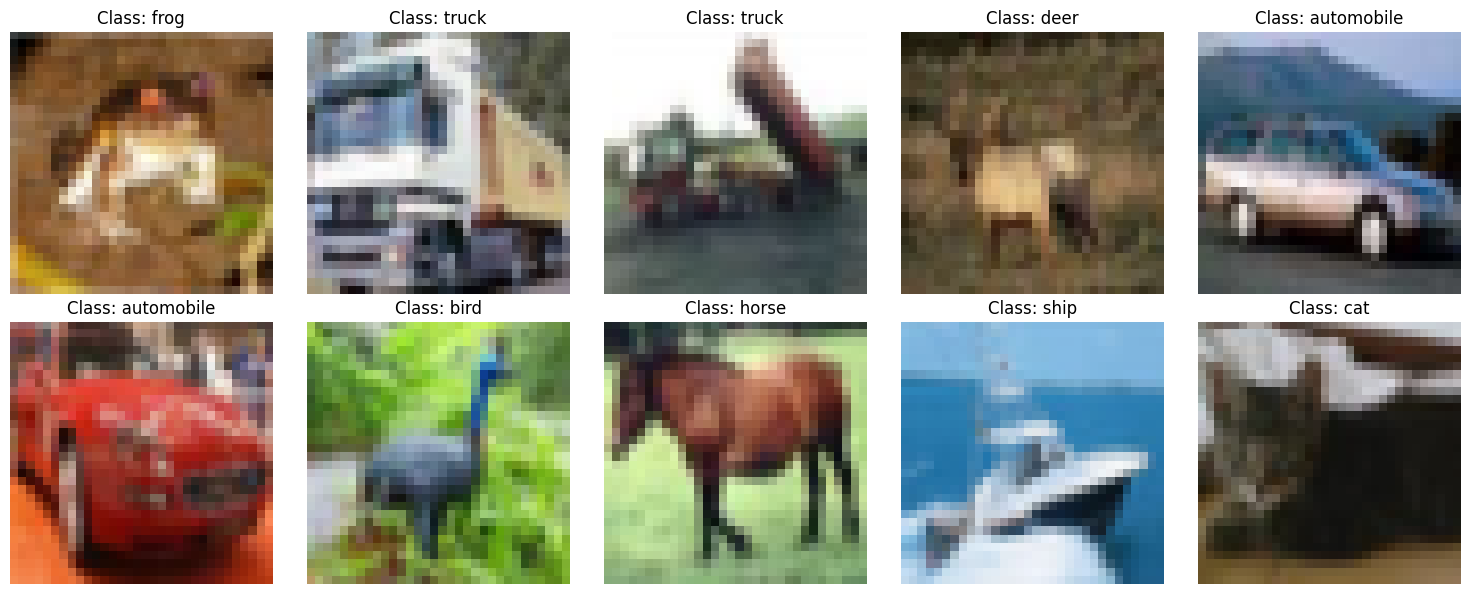

In [ ]:
# Create train, validation, and test sets for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# 10 classes of CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Denormalization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset[i]
    image = denormalize(image, mean, std)
    class_name = classes[label]
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0).clamp(0, 1))  #  ensure values are in [0, 1]
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):

    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss = criterion(outputs, y)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_accuracy = correct / total
        val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            epochs_no_improve = 0
            best_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at Epoch {epoch+1}")
                break

    # Plot training and validation loss
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.show()

    return model, train_loss_history, val_loss_history


The base model: <br>2 Convolution and max pool layers <br>1 fully connected layer(fc)

In [ ]:
class CNN(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

Epoch 1/50, Train Loss: 2.1535, Validation Loss: 2.0120, Validation Accuracy: 0.3082
Epoch 2/50, Train Loss: 1.9385, Validation Loss: 1.8448, Validation Accuracy: 0.3578
Epoch 3/50, Train Loss: 1.8050, Validation Loss: 1.7317, Validation Accuracy: 0.4096
Epoch 4/50, Train Loss: 1.7072, Validation Loss: 1.6433, Validation Accuracy: 0.4306
Epoch 5/50, Train Loss: 1.6290, Validation Loss: 1.5754, Validation Accuracy: 0.4522
Epoch 6/50, Train Loss: 1.5672, Validation Loss: 1.5248, Validation Accuracy: 0.4646
Epoch 7/50, Train Loss: 1.5185, Validation Loss: 1.4811, Validation Accuracy: 0.4832
Epoch 8/50, Train Loss: 1.4796, Validation Loss: 1.4499, Validation Accuracy: 0.4986
Epoch 9/50, Train Loss: 1.4465, Validation Loss: 1.4243, Validation Accuracy: 0.5002
Epoch 10/50, Train Loss: 1.4186, Validation Loss: 1.4005, Validation Accuracy: 0.5100
Epoch 11/50, Train Loss: 1.3952, Validation Loss: 1.3804, Validation Accuracy: 0.5120
Epoch 12/50, Train Loss: 1.3736, Validation Loss: 1.3591, Valid

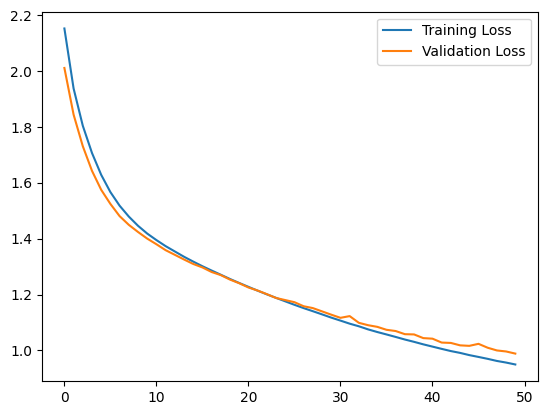

Epoch 1/50, Train Loss: 1.7260, Validation Loss: 1.5137, Validation Accuracy: 0.4462
Epoch 2/50, Train Loss: 1.3754, Validation Loss: 1.2755, Validation Accuracy: 0.5550
Epoch 3/50, Train Loss: 1.2460, Validation Loss: 1.1872, Validation Accuracy: 0.5844
Epoch 4/50, Train Loss: 1.1476, Validation Loss: 1.1034, Validation Accuracy: 0.6142
Epoch 5/50, Train Loss: 1.0698, Validation Loss: 1.1416, Validation Accuracy: 0.5864
Epoch 6/50, Train Loss: 1.0042, Validation Loss: 0.9945, Validation Accuracy: 0.6592
Epoch 7/50, Train Loss: 0.9535, Validation Loss: 0.9686, Validation Accuracy: 0.6702
Epoch 8/50, Train Loss: 0.9115, Validation Loss: 0.9616, Validation Accuracy: 0.6706
Epoch 9/50, Train Loss: 0.8742, Validation Loss: 0.9806, Validation Accuracy: 0.6576
Epoch 10/50, Train Loss: 0.8404, Validation Loss: 0.8883, Validation Accuracy: 0.6920
Epoch 11/50, Train Loss: 0.8121, Validation Loss: 0.8810, Validation Accuracy: 0.6996
Epoch 12/50, Train Loss: 0.7827, Validation Loss: 0.8645, Valid

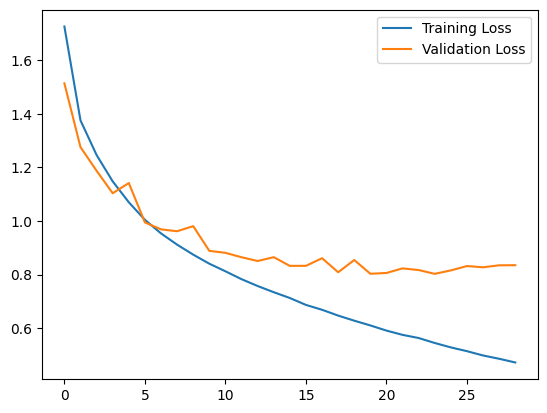

Epoch 1/50, Train Loss: 1.4881, Validation Loss: 1.3072, Validation Accuracy: 0.5454
Epoch 2/50, Train Loss: 1.0811, Validation Loss: 1.0252, Validation Accuracy: 0.6438
Epoch 3/50, Train Loss: 0.9180, Validation Loss: 1.0018, Validation Accuracy: 0.6560
Epoch 4/50, Train Loss: 0.8128, Validation Loss: 0.8791, Validation Accuracy: 0.7096
Epoch 5/50, Train Loss: 0.7364, Validation Loss: 0.9253, Validation Accuracy: 0.6944
Epoch 6/50, Train Loss: 0.6767, Validation Loss: 0.9028, Validation Accuracy: 0.7034
Epoch 7/50, Train Loss: 0.6270, Validation Loss: 0.9068, Validation Accuracy: 0.7064
Epoch 8/50, Train Loss: 0.5830, Validation Loss: 1.0329, Validation Accuracy: 0.6874
Epoch 9/50, Train Loss: 0.5458, Validation Loss: 0.9763, Validation Accuracy: 0.6964
Early stopping at Epoch 9


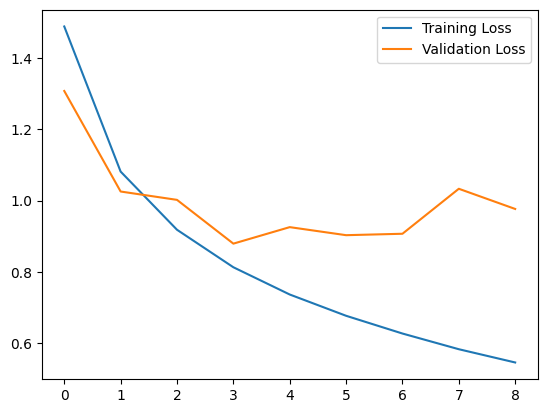

Best learning rate: 0.01


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001, 0.01, 0.1]

best_val_loss = float('inf')

for lr in learning_rates:
    model = CNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    _, _, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)
    if min(val_loss_history) < best_val_loss:
        best_val_loss = min(val_loss_history)
        best_lr = lr


print(f"Best learning rate: {best_lr}")


Epoch 1/50, Train Loss: 1.6952, Validation Loss: 1.4233, Validation Accuracy: 0.5038
Epoch 2/50, Train Loss: 1.3521, Validation Loss: 1.2829, Validation Accuracy: 0.5534
Epoch 3/50, Train Loss: 1.2064, Validation Loss: 1.1371, Validation Accuracy: 0.6024
Epoch 4/50, Train Loss: 1.1007, Validation Loss: 1.1071, Validation Accuracy: 0.6142
Epoch 5/50, Train Loss: 1.0217, Validation Loss: 0.9985, Validation Accuracy: 0.6478
Epoch 6/50, Train Loss: 0.9598, Validation Loss: 0.9836, Validation Accuracy: 0.6546
Epoch 7/50, Train Loss: 0.9069, Validation Loss: 0.9105, Validation Accuracy: 0.6870
Epoch 8/50, Train Loss: 0.8658, Validation Loss: 0.9011, Validation Accuracy: 0.6898
Epoch 9/50, Train Loss: 0.8263, Validation Loss: 0.8581, Validation Accuracy: 0.7042
Epoch 10/50, Train Loss: 0.7943, Validation Loss: 0.8608, Validation Accuracy: 0.7048
Epoch 11/50, Train Loss: 0.7653, Validation Loss: 0.8511, Validation Accuracy: 0.7064
Epoch 12/50, Train Loss: 0.7363, Validation Loss: 0.8319, Valid

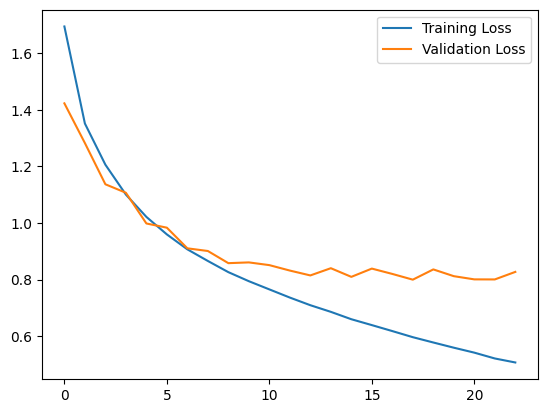

In [ ]:
criterion = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum = 0.2)
_, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)



Model 2<br>
2 convolution & max pool layers
<br>2 fully connected layers


In [ ]:
class CNN_2(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000)
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)

    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

Epoch 1/50, Train Loss: 2.2427, Validation Loss: 2.1761, Validation Accuracy: 0.2520
Epoch 2/50, Train Loss: 2.0985, Validation Loss: 2.0244, Validation Accuracy: 0.2866
Epoch 3/50, Train Loss: 1.9630, Validation Loss: 1.9007, Validation Accuracy: 0.3256
Epoch 4/50, Train Loss: 1.8575, Validation Loss: 1.8165, Validation Accuracy: 0.3616
Epoch 5/50, Train Loss: 1.7858, Validation Loss: 1.7529, Validation Accuracy: 0.3844
Epoch 6/50, Train Loss: 1.7276, Validation Loss: 1.7011, Validation Accuracy: 0.4004
Epoch 7/50, Train Loss: 1.6756, Validation Loss: 1.6487, Validation Accuracy: 0.4170
Epoch 8/50, Train Loss: 1.6278, Validation Loss: 1.6046, Validation Accuracy: 0.4270
Epoch 9/50, Train Loss: 1.5863, Validation Loss: 1.5652, Validation Accuracy: 0.4436
Epoch 10/50, Train Loss: 1.5477, Validation Loss: 1.5307, Validation Accuracy: 0.4540
Epoch 11/50, Train Loss: 1.5136, Validation Loss: 1.5039, Validation Accuracy: 0.4604
Epoch 12/50, Train Loss: 1.4830, Validation Loss: 1.4765, Valid

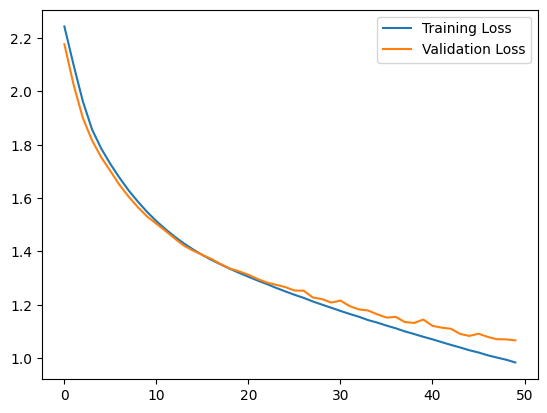

Epoch 1/50, Train Loss: 1.8918, Validation Loss: 1.6533, Validation Accuracy: 0.4052
Epoch 2/50, Train Loss: 1.5200, Validation Loss: 1.4126, Validation Accuracy: 0.4912
Epoch 3/50, Train Loss: 1.3624, Validation Loss: 1.2853, Validation Accuracy: 0.5340
Epoch 4/50, Train Loss: 1.2473, Validation Loss: 1.2081, Validation Accuracy: 0.5758
Epoch 5/50, Train Loss: 1.1551, Validation Loss: 1.1062, Validation Accuracy: 0.6186
Epoch 6/50, Train Loss: 1.0742, Validation Loss: 1.0874, Validation Accuracy: 0.6168
Epoch 7/50, Train Loss: 1.0052, Validation Loss: 0.9924, Validation Accuracy: 0.6474
Epoch 8/50, Train Loss: 0.9447, Validation Loss: 0.9917, Validation Accuracy: 0.6498
Epoch 9/50, Train Loss: 0.8849, Validation Loss: 0.9454, Validation Accuracy: 0.6680
Epoch 10/50, Train Loss: 0.8341, Validation Loss: 0.9415, Validation Accuracy: 0.6678
Epoch 11/50, Train Loss: 0.7826, Validation Loss: 0.9119, Validation Accuracy: 0.6768
Epoch 12/50, Train Loss: 0.7339, Validation Loss: 0.8810, Valid

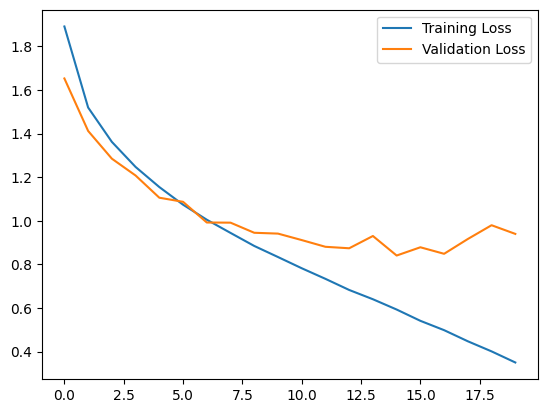

Epoch 1/50, Train Loss: 1.5467, Validation Loss: 1.2535, Validation Accuracy: 0.5582
Epoch 2/50, Train Loss: 1.0833, Validation Loss: 0.9932, Validation Accuracy: 0.6564
Epoch 3/50, Train Loss: 0.8380, Validation Loss: 0.9191, Validation Accuracy: 0.6846
Epoch 4/50, Train Loss: 0.6333, Validation Loss: 0.8705, Validation Accuracy: 0.7086
Epoch 5/50, Train Loss: 0.4387, Validation Loss: 0.8972, Validation Accuracy: 0.7134
Epoch 6/50, Train Loss: 0.2735, Validation Loss: 0.9476, Validation Accuracy: 0.7224
Epoch 7/50, Train Loss: 0.1479, Validation Loss: 1.2122, Validation Accuracy: 0.7132
Epoch 8/50, Train Loss: 0.0853, Validation Loss: 1.2765, Validation Accuracy: 0.7334
Epoch 9/50, Train Loss: 0.0447, Validation Loss: 1.3312, Validation Accuracy: 0.7318
Early stopping at Epoch 9


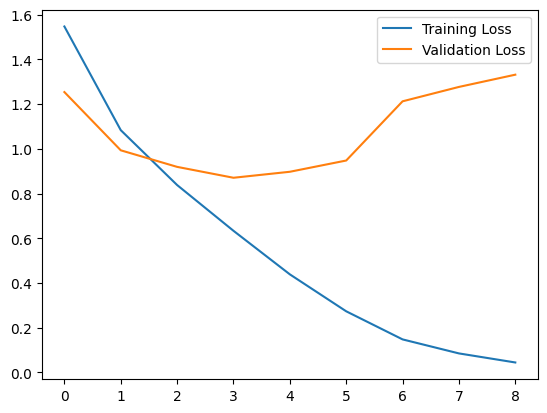

Best learning rate: 0.01


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001, 0.01, 0.1]
best_val_loss = float('inf')

for lr in learning_rates:
    model2 = CNN_2().to(device)
    optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
    _, _, val_loss_history = train_model(model2, train_loader, val_loader, criterion, optimizer)
    if min(val_loss_history) < best_val_loss:
        best_val_loss = min(val_loss_history)
        best_lr = lr

print(f"Best learning rate: {best_lr}")


Epoch 1/50, Train Loss: 1.9064, Validation Loss: 1.6388, Validation Accuracy: 0.4206
Epoch 2/50, Train Loss: 1.5418, Validation Loss: 1.4521, Validation Accuracy: 0.4850
Epoch 3/50, Train Loss: 1.4012, Validation Loss: 1.3320, Validation Accuracy: 0.5248
Epoch 4/50, Train Loss: 1.3111, Validation Loss: 1.2503, Validation Accuracy: 0.5574
Epoch 5/50, Train Loss: 1.2299, Validation Loss: 1.1877, Validation Accuracy: 0.5816
Epoch 6/50, Train Loss: 1.1608, Validation Loss: 1.1252, Validation Accuracy: 0.6008
Epoch 7/50, Train Loss: 1.0948, Validation Loss: 1.0843, Validation Accuracy: 0.6128
Epoch 8/50, Train Loss: 1.0350, Validation Loss: 1.0064, Validation Accuracy: 0.6444
Epoch 9/50, Train Loss: 0.9827, Validation Loss: 0.9882, Validation Accuracy: 0.6490
Epoch 10/50, Train Loss: 0.9324, Validation Loss: 0.9456, Validation Accuracy: 0.6702
Epoch 11/50, Train Loss: 0.8904, Validation Loss: 0.9059, Validation Accuracy: 0.6836
Epoch 12/50, Train Loss: 0.8507, Validation Loss: 0.9066, Valid

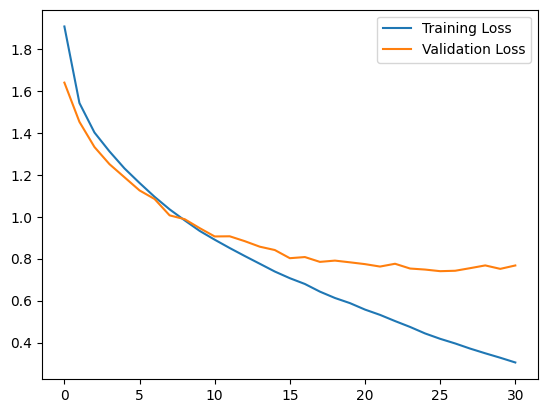

In [ ]:
# add dropout
criterion = nn.CrossEntropyLoss()
model2 = CNN_2(p=0.5).to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
_, train_loss_history, val_loss_history = train_model(model2, train_loader, val_loader, criterion, optimizer)



Model 3:
<br>2 convolution and max pool layers
<br>3 fully connected layers
<br>dropout value p = 0.5

In [ ]:
class CNN_3(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000)
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        return(x)


Training with learning rate: 0.01
Epoch 1/50, Train Loss: 2.1217, Validation Loss: 1.8928, Validation Accuracy: 0.3140
Epoch 2/50, Train Loss: 1.7827, Validation Loss: 1.6029, Validation Accuracy: 0.4110
Epoch 3/50, Train Loss: 1.5692, Validation Loss: 1.4542, Validation Accuracy: 0.4740
Epoch 4/50, Train Loss: 1.4626, Validation Loss: 1.3825, Validation Accuracy: 0.5052
Epoch 5/50, Train Loss: 1.3844, Validation Loss: 1.3301, Validation Accuracy: 0.5190
Epoch 6/50, Train Loss: 1.3186, Validation Loss: 1.2483, Validation Accuracy: 0.5486
Epoch 7/50, Train Loss: 1.2546, Validation Loss: 1.2207, Validation Accuracy: 0.5628
Epoch 8/50, Train Loss: 1.1918, Validation Loss: 1.1406, Validation Accuracy: 0.5812
Epoch 9/50, Train Loss: 1.1360, Validation Loss: 1.1047, Validation Accuracy: 0.5992
Epoch 10/50, Train Loss: 1.0836, Validation Loss: 1.0447, Validation Accuracy: 0.6246
Epoch 11/50, Train Loss: 1.0310, Validation Loss: 1.0208, Validation Accuracy: 0.6410
Epoch 12/50, Train Loss: 0.9

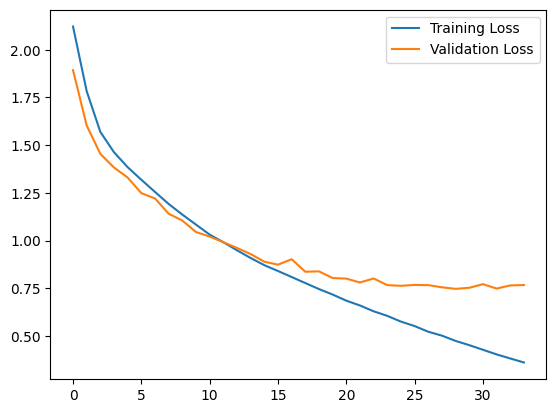

New best model saved with learning rate: 0.01 at path best_model3.pth

Training with learning rate: 0.1
Epoch 1/50, Train Loss: 1.7158, Validation Loss: 1.3430, Validation Accuracy: 0.5098
Epoch 2/50, Train Loss: 1.2776, Validation Loss: 1.0653, Validation Accuracy: 0.6168
Epoch 3/50, Train Loss: 1.0614, Validation Loss: 0.9799, Validation Accuracy: 0.6626
Epoch 4/50, Train Loss: 0.9035, Validation Loss: 0.8903, Validation Accuracy: 0.6894
Epoch 5/50, Train Loss: 0.7812, Validation Loss: 0.8016, Validation Accuracy: 0.7246
Epoch 6/50, Train Loss: 0.6734, Validation Loss: 0.8031, Validation Accuracy: 0.7310
Epoch 7/50, Train Loss: 0.5846, Validation Loss: 0.8686, Validation Accuracy: 0.7076
Epoch 8/50, Train Loss: 0.5020, Validation Loss: 0.7615, Validation Accuracy: 0.7494
Epoch 9/50, Train Loss: 0.4213, Validation Loss: 0.8683, Validation Accuracy: 0.7404
Epoch 10/50, Train Loss: 0.3613, Validation Loss: 0.8476, Validation Accuracy: 0.7380
Epoch 11/50, Train Loss: 0.3094, Validation L

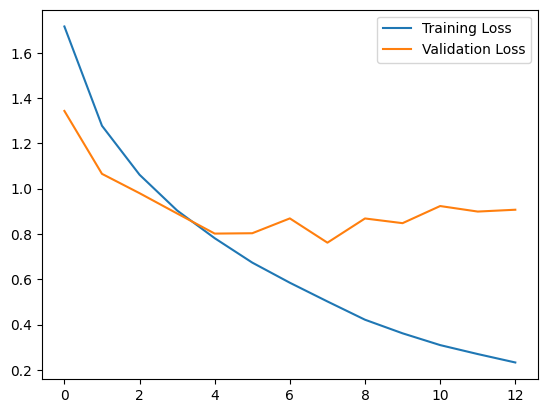

Best learning rate: 0.01


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.01, 0.1]
best_val_loss = float('inf')
best_model_path = 'best_model3.pth'


for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model3 = CNN_3(p=0.5).to(device)
    optimizer = torch.optim.SGD(model3.parameters(), lr=lr)
    _, _, val_loss_history = train_model(model3, train_loader, val_loader, criterion, optimizer)
    if min(val_loss_history) < best_val_loss:
        best_val_loss = min(val_loss_history)
        best_lr = lr
        # Save this model
        torch.save(model3.state_dict(), best_model_path)
        print(f"New best model saved with learning rate: {lr} at path {best_model_path}")

print(f"Best learning rate: {best_lr}")


In [ ]:
# Load and evaluate the best model on the test set
model3 = CNN_3().to(device)
model3.load_state_dict(torch.load(best_model_path))
model3.eval()

correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model3(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f"Accuracy of the best model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the best model on the test dataset: 77.18%


 The accuracy did not improve much after adding another hidden layer in fully connected layer, now try adding convolution layer<br><br>
model 4:
<br>3 convolution & max pool layers
<br>3 fully connected layers


In [ ]:
class CNN_4(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        return(x)


Training with learning rate: 0.01
Epoch 1/50, Train Loss: 2.2829, Validation Loss: 2.1832, Validation Accuracy: 0.2384
Epoch 2/50, Train Loss: 2.0146, Validation Loss: 1.8693, Validation Accuracy: 0.3036
Epoch 3/50, Train Loss: 1.8018, Validation Loss: 1.6452, Validation Accuracy: 0.3866
Epoch 4/50, Train Loss: 1.6568, Validation Loss: 1.5282, Validation Accuracy: 0.4360
Epoch 5/50, Train Loss: 1.5483, Validation Loss: 1.4435, Validation Accuracy: 0.4644
Epoch 6/50, Train Loss: 1.4623, Validation Loss: 1.3651, Validation Accuracy: 0.5016
Epoch 7/50, Train Loss: 1.3886, Validation Loss: 1.3114, Validation Accuracy: 0.5286
Epoch 8/50, Train Loss: 1.3252, Validation Loss: 1.2274, Validation Accuracy: 0.5580
Epoch 9/50, Train Loss: 1.2599, Validation Loss: 1.1775, Validation Accuracy: 0.5810
Epoch 10/50, Train Loss: 1.2014, Validation Loss: 1.1533, Validation Accuracy: 0.5866
Epoch 11/50, Train Loss: 1.1475, Validation Loss: 1.1011, Validation Accuracy: 0.6056
Epoch 12/50, Train Loss: 1.0

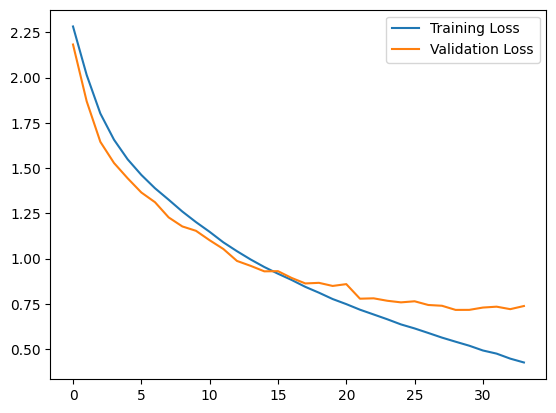

New best model saved with learning rate: 0.01 at path best_model4.pth

Training with learning rate: 0.1
Epoch 1/50, Train Loss: 1.8443, Validation Loss: 1.4074, Validation Accuracy: 0.4928
Epoch 2/50, Train Loss: 1.3677, Validation Loss: 1.1462, Validation Accuracy: 0.5864
Epoch 3/50, Train Loss: 1.1070, Validation Loss: 1.0062, Validation Accuracy: 0.6484
Epoch 4/50, Train Loss: 0.9220, Validation Loss: 0.9124, Validation Accuracy: 0.6868
Epoch 5/50, Train Loss: 0.7827, Validation Loss: 0.8556, Validation Accuracy: 0.7084
Epoch 6/50, Train Loss: 0.6792, Validation Loss: 0.7954, Validation Accuracy: 0.7284
Epoch 7/50, Train Loss: 0.5818, Validation Loss: 0.7638, Validation Accuracy: 0.7496
Epoch 8/50, Train Loss: 0.5013, Validation Loss: 0.7334, Validation Accuracy: 0.7564
Epoch 9/50, Train Loss: 0.4323, Validation Loss: 0.7924, Validation Accuracy: 0.7566
Epoch 10/50, Train Loss: 0.3710, Validation Loss: 0.8160, Validation Accuracy: 0.7582
Epoch 11/50, Train Loss: 0.3237, Validation L

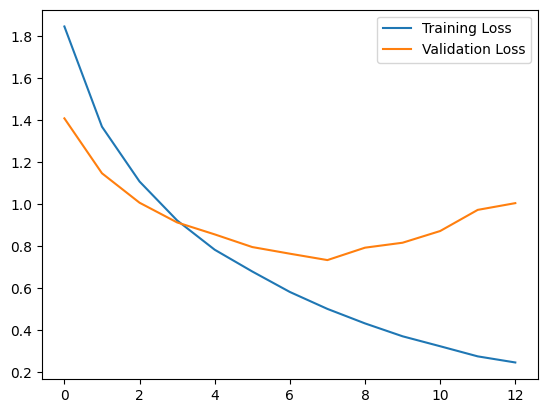

Best learning rate: 0.01


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.01, 0.1]
best_val_loss = float('inf')
best_model_path = 'best_model4.pth'


for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model4 = CNN_4(p=0.5).to(device)
    optimizer = torch.optim.SGD(model4.parameters(), lr=lr)
    _, _, val_loss_history = train_model(model4, train_loader, val_loader, criterion, optimizer)
    if min(val_loss_history) < best_val_loss:
        best_val_loss = min(val_loss_history)
        best_lr = lr
        # Save this model
        torch.save(model4.state_dict(), best_model_path)
        print(f"New best model saved with learning rate: {lr} at path {best_model_path}")

print(f"Best learning rate: {best_lr}")


In [ ]:
# Load and evaluate the best model on the test set
model4 = CNN_4().to(device)
model4.load_state_dict(torch.load(best_model_path))
model4.eval()

correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model4(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f"Accuracy of the best model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the best model on the test dataset: 76.06%
